# CHE2241_Project 2 _ Abdulmalik

In [1]:
#Importing the required libraries

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
from scipy.optimize import minimize

### Kinetic models from my selected paper

$$ r_1 = \mu C_x (1-\frac{C_x}{C_{xm}})$$


$$ r_2 = k_{p1}C_sC_x$$


$$ r_2 = k_{p2}C_sC_x$$


$$\frac{dC_s}{dt} =-Y_{S/x}r_1 - Y_{S/p1}r_2 - Y_{S/p2}r_3$$


$$\frac{dC_p}{dt} = r_2 $$


$$\frac{dC_X}{dt} = r_1 $$

$$\frac{dC_{BP}}{dt} = Y_{S/BP}r_2 + r_3$$


Where, $$k_{p1} = \alpha e^{-\beta C_{S0}} $$

### Parameters to be estimated

$C_{xm}$, $k_{p2}$, $\mu$, $Y_{Sp1}$, $Y_{Sp2}$, $Y_{SBP}$, $Y_{SX}$, $\alpha$, $\beta$

In [2]:
time = np.linspace(0, 50, 200)  #time in hours from the paper

In [3]:
# initial conditions
Cx0 = 0.008 # g/L
Cs0 = 36    # g/L
Cp0 = 0     # g/L
CBP0 = 0    # g/L

initial_values = [Cx0, Cs0, Cp0, CBP0]

#Parameters values from the paper


Cxm = 6.587  # g/L
kp2 = 0.007  # L/g.h
mu = 0.878   # h-1
Y_Sp1 = 1.337  # g/g 
Y_Sp2 = 0.585  # g/g
Y_SBP = 0.363  # g/g
Y_SX = 0.415   # g/g
alpha = 0.157  # L/g.h]pp
Beta = 0.073   # g/L

params1 = Cxm, kp2, mu, Y_Sp1, Y_Sp2,Y_SBP, Y_SX, alpha, Beta 

In [4]:
#Replicating the models from the paper

def ode(z,t):
    Cx = z[0]
    Cs = z[1]
    Cp = z[2]
    CBP = z[3]
    
    Cxm, kp2, mu, Y_Sp1, Y_Sp2,Y_SBP, Y_SX, alpha, Beta  = params1
    
    kp1 = alpha*np.exp(-Beta*Cs0)
    r1 = mu*Cx*(1-Cx/Cxm)
    r2 = kp1*Cs*Cx
    r3 = kp2*Cs*Cx
    
    dCxdt = r1
    dCsdt  = -Y_SX*r1 - Y_Sp1*r2 - Y_Sp2*r3
    dCpdt = r2
    dCBPdt = Y_SBP*r2 + r3
    
    return([dCxdt, dCsdt, dCpdt, dCBPdt])

result = odeint(ode, initial_values, time)

Cx = result[:,0]
Cs = result[:,1]
Cp = result[:,2]
CBP = result[:,3]

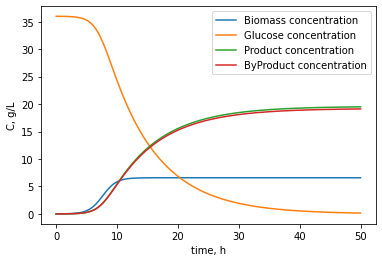

In [5]:
# Plotting the models

plt.plot(time, result[:,0], label = 'Biomass concentration')
plt.plot(time, result[:,1], label = 'Glucose concentration')
plt.plot(time, result[:,2], label = 'Product concentration')
plt.plot(time, result[:,3], label = 'ByProduct concentration')
plt.xlabel ('time, h')
plt.ylabel ('C, g/L')
plt.legend()

### Analysis focusing on substrate compositions

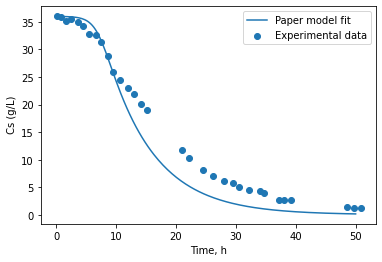

In [6]:
# Substrate concentrations
Substrate = result[:,1]

# Experimental values for Substrate concentrations

Substrate_Experimental = pd.read_csv('Potato Substrate concentration.csv', header = 0)


# print(Substrate_Experimental)
Experimental_time = Substrate_Experimental['time, h']
Experimental_Conc = Substrate_Experimental ['Cs, g/L']

plt.scatter(Experimental_time, Experimental_Conc, label ='Experimental data')
plt.plot(time, Substrate, label ='Paper model fit')
plt.xlabel ('Time, h')
plt.ylabel(' Cs (g/L)')
plt.legend()

#### Minimizing the model parameters and fitting it again

Optimized Parameters: [ 4.81692947e+00  6.22938074e-03  1.17442302e+00  1.27638921e+00
  4.59323791e-01  9.08380765e+03 -2.27100266e-01  1.36848411e-01
  7.21742792e-02]


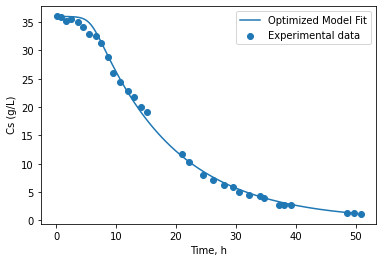

In [7]:
from scipy.optimize import curve_fit

def objective_function(time, Cxm, kp2, mu, Y_Sp1, Y_Sp2, Y_SBP, Y_SX, alpha, Beta):
    global params1
    params1 = (Cxm, kp2, mu, Y_Sp1, Y_Sp2, Y_SBP, Y_SX, alpha, Beta)
    result = odeint(ode, initial_values, time)
    model_prediction = result[:, 1]  # Cs column
    return model_prediction

initial_guess = [7.0,0.008,0.9,1.4,0.6,0.4,0.4,0.15,0.07]

# Perform optimization
optimized_params, covariance = curve_fit(objective_function, Experimental_time, Experimental_Conc, p0=initial_guess)

# Display the optimized parameters
print("Optimized Parameters:", optimized_params)

# Update the parameters with the optimized values
Cxm, kp2, mu, Y_Sp1, Y_Sp2, Y_SBP, Y_SX, alpha, Beta = optimized_params

# Plot the optimized model against experimental data
result = odeint(ode, initial_values, time)
plt.scatter(Experimental_time, Experimental_Conc, label='Experimental data')
plt.plot(time, result[:, 1], label='Optimized Model Fit')
plt.xlabel ('Time, h')
plt.ylabel(' Cs (g/L)')
plt.legend()
plt.show()


In [8]:
#Optimized parameters
Cxm_opt = 4.8169
kp2_opt = 0.0062
mu_opt = 1.1744
Y_Sp1_opt = 1.2764
Y_Sp2_opt = 0.4593
Y_SBP_opt = 0.0091
Y_SX_opt = -0.2271
alpha_opt = 0.1368
Beta_opt = 0.0722


#### Bifurcation Analysis

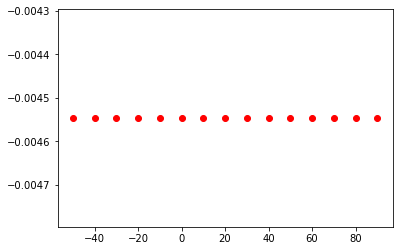

In [10]:
#Bifurcation Analysis
mu_values = np.arange(-50, 100, 10) 

def Bifuc (mu, params):
    
    Cxm, kp2, Y_Sp1, Y_Sp2, Y_SBP, Y_SX, alpha, Beta = params
    
    Cx = initial_values[0]
    Cs = initial_values[1]
    Cp = initial_values[2]
    CBP = initial_values[3]
    
    
    kp1 = alpha*np.exp(-Beta*Cs0)
    r1 = mu*Cx*(1-Cx/Cxm)
    r2 = kp1*Cs*Cx
    r3 = kp2*Cs*Cx
    
    dCxdt = r1
    dCsdt  = -Y_SX*r1 - Y_Sp1*r2 - Y_Sp2*r3
    dCpdt = r2
    dCBPdt = Y_SBP*r2 + r3
    
    return dCsdt

Optimized_params = [Cxm_opt, kp2_opt, Y_Sp1_opt, Y_Sp2_opt, Y_SBP_opt, Y_SX_opt, alpha_opt, Beta_opt]

dCsdt_values = [Bifuc (kp2, Optimized_params) for mu in mu_values]

plt.plot(mu_values, dCsdt_values, 'ro')

C:\Users\ABDULM~1\AppData\Local\Temp/ipykernel_4120/1622854501.py:15: RuntimeWarning: divide by zero encountered in divide
  r1 = mu*Cx*(1-Cx/Cxm)


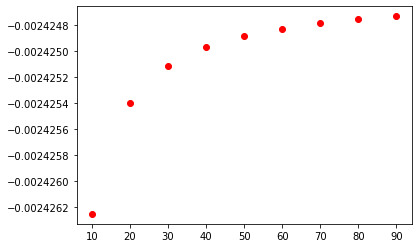

In [11]:
#Bifurcation Analysis
Cxm_values = np.arange(0, 100, 10) 

def Bifuc (Cxm, params):
    
    kp2, mu, Y_Sp1, Y_Sp2, Y_SBP, Y_SX, alpha, Beta = params
    
    Cx = initial_values[0]
    Cs = initial_values[1]
    Cp = initial_values[2]
    CBP = initial_values[3]
    
    
    kp1 = alpha*np.exp(-Beta*Cs0)
    r1 = mu*Cx*(1-Cx/Cxm)
    r2 = kp1*Cs*Cx
    r3 = kp2*Cs*Cx
    
    dCxdt = r1
    dCsdt  = -Y_SX*r1 - Y_Sp1*r2 - Y_Sp2*r3
    dCpdt = r2
    dCBPdt = Y_SBP*r2 + r3
    
    return dCsdt

Optimized_params = [kp2_opt, mu_opt, Y_Sp1_opt, Y_Sp2_opt, Y_SBP_opt, Y_SX_opt, alpha_opt, Beta_opt]

dCsdt_values = [Bifuc (Cxm, Optimized_params) for Cxm in Cxm_values]

plt.plot(Cxm_values, dCsdt_values, 'ro')

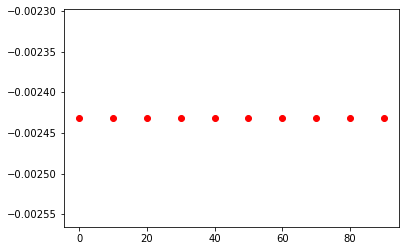

In [12]:
#Bifurcation Analysis
Beta_values = np.arange(0, 100, 10) 

def Bifuc (Cxm, params):
    
    Cxm, kp2, mu, Y_Sp1, Y_Sp2, Y_SBP, Y_SX, alpha, = params
    
    Cx = initial_values[0]
    Cs = initial_values[1]
    Cp = initial_values[2]
    CBP = initial_values[3]
    
    
    kp1 = alpha*np.exp(-Beta*Cs0)
    r1 = mu*Cx*(1-Cx/Cxm)
    r2 = kp1*Cs*Cx
    r3 = kp2*Cs*Cx
    
    dCxdt = r1
    dCsdt  = -Y_SX*r1 - Y_Sp1*r2 - Y_Sp2*r3
    dCpdt = r2
    dCBPdt = Y_SBP*r2 + r3
    
    return dCsdt

Optimized_params = [Cxm, kp2_opt, mu_opt, Y_Sp1_opt, Y_Sp2_opt, Y_SBP_opt, Y_SX_opt, alpha_opt]

dCsdt_values = [Bifuc (Beta, Optimized_params) for Beta in Beta_values]

plt.plot(Beta_values, dCsdt_values, 'ro')

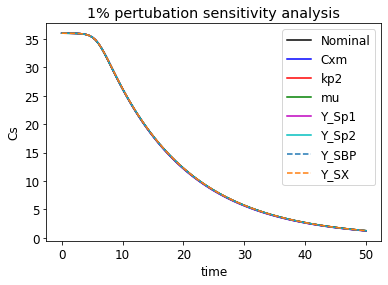

In [13]:
#1% pertubation sensitivity analysis

def sens1(z,t, Cxm, kp2, mu, Y_Sp1, Y_Sp2,Y_SBP, Y_SX, alpha, Beta ):
    Cx = z[0]
    Cs = z[1]
    Cp = z[2]
    CBP = z[3]
    
    kp1 = alpha*np.exp(-Beta*Cs0)
    r1 = mu*Cx*(1-Cx/Cxm)
    r2 = kp1*Cs*Cx
    r3 = kp2*Cs*Cx
    
    dCxdt = r1
    dCsdt  = -Y_SX*r1 - Y_Sp1*r2 - Y_Sp2*r3
    dCpdt = r2
    dCBPdt = Y_SBP*r2 + r3
    
    return([dCxdt, dCsdt, dCpdt, dCBPdt])

timesteps = np.linspace(0,50,100)

y = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y1 = odeint(sens1, initial_values, timesteps, args = (4.8169*1.01, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y2 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062*1.01, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y3 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744*1.01, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y4 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764*1.01, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y5 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593*1.01, 0.0091, -0.2271, 0.1368, 0.0722))
y6 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091*1.01, -0.2271, 0.1368, 0.0722))
y7 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271*1.01, 0.1368, 0.0722))
# y8 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368*1.01, 0.0722))
# y9 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722*1.01))

# Plot the numerical solution
plt.rcParams.update({'font.size': 12})  # increase the font size
plt.xlabel("time")
plt.ylabel("Cs")
plt.title ('1% pertubation sensitivity analysis')
plt.plot(timesteps, y[:,1],'k', label = "Nominal");
plt.plot(timesteps, y1[:,1],'b', label = "Cxm");
plt.plot(timesteps, y2[:,1],'r', label = "kp2");
plt.plot(timesteps, y3[:,1],'g', label = "mu");
plt.plot(timesteps, y4[:,1],'m', label = "Y_Sp1");
plt.plot(timesteps, y5[:,1],'c', label = "Y_Sp2");
plt.plot(timesteps, y6[:,1],'--', label = "Y_SBP");
plt.plot(timesteps, y7[:,1],'--', label = "Y_SX");
plt.legend()


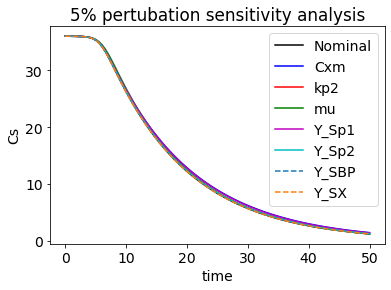

In [14]:
#5% pertubation

y = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y1 = odeint(sens1, initial_values, timesteps, args = (4.8169*0.95, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y2 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062*0.95, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y3 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744*0.95, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y4 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764*0.95, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y5 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593*0.95, 0.0091, -0.2271, 0.1368, 0.0722))
y6 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091*0.95, -0.2271, 0.1368, 0.0722))
y7 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271*0.95, 0.1368, 0.0722))
# y8 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368*1.01, 0.0722))
# y9 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722*1.01))

# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("time")
plt.ylabel("Cs")
plt.title ('5% pertubation sensitivity analysis')
plt.plot(timesteps, y[:,1],'k', label = "Nominal");
plt.plot(timesteps, y1[:,1],'b', label = "Cxm");
plt.plot(timesteps, y2[:,1],'r', label = "kp2");
plt.plot(timesteps, y3[:,1],'g', label = "mu");
plt.plot(timesteps, y4[:,1],'m', label = "Y_Sp1");
plt.plot(timesteps, y5[:,1],'c', label = "Y_Sp2");
plt.plot(timesteps, y6[:,1],'--', label = "Y_SBP");
plt.plot(timesteps, y7[:,1],'--', label = "Y_SX");
plt.legend()

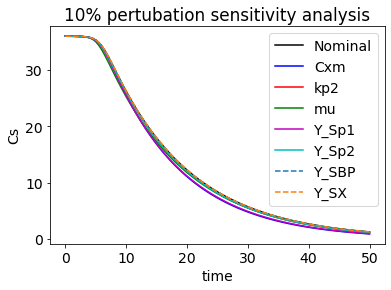

In [15]:
#10% pertubation

y = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y1 = odeint(sens1, initial_values, timesteps, args = (4.8169*1.1, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y2 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062*1.1, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y3 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744*1.1, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y4 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764*1.1, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y5 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593*1.1, 0.0091, -0.2271, 0.1368, 0.0722))
y6 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091*1.1, -0.2271, 0.1368, 0.0722))
y7 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271*1.1, 0.1368, 0.0722))
# y8 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368*1.01, 0.0722))
# y9 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722*1.01))

# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("time")
plt.ylabel("Cs")
plt.title ('10% pertubation sensitivity analysis')
plt.plot(timesteps, y[:,1],'k', label = "Nominal");
plt.plot(timesteps, y1[:,1],'b', label = "Cxm");
plt.plot(timesteps, y2[:,1],'r', label = "kp2");
plt.plot(timesteps, y3[:,1],'g', label = "mu");
plt.plot(timesteps, y4[:,1],'m', label = "Y_Sp1");
plt.plot(timesteps, y5[:,1],'c', label = "Y_Sp2");
plt.plot(timesteps, y6[:,1],'--', label = "Y_SBP");
plt.plot(timesteps, y7[:,1],'--', label = "Y_SX");
plt.legend()

1.2449166898563315


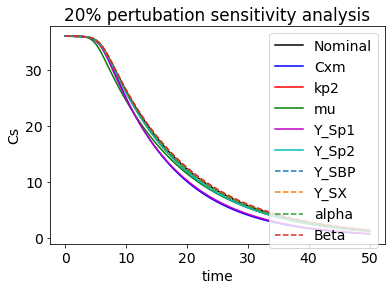

In [16]:
#20%  pertubation

y = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y1 = odeint(sens1, initial_values, timesteps, args = (4.8169*1.2, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y2 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062*1.2, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y3 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744*1.2, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y4 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764*1.2, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722))
y5 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593*1.2, 0.0091, -0.2271, 0.1368, 0.0722))
y6 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091*1.2, -0.2271, 0.1368, 0.0722))
y7 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271*1.2, 0.1368, 0.0722))
y8 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368*1.01, 0.0722))
y9 = odeint(sens1, initial_values, timesteps, args = (4.8169, 0.0062, 1.1744, 1.2764, 0.4593, 0.0091, -0.2271, 0.1368, 0.0722*1.01))

# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("time")
plt.ylabel("Cs")
plt.title ('20% pertubation sensitivity analysis')
plt.plot(timesteps, y[:,1],'k', label = "Nominal");
plt.plot(timesteps, y1[:,1],'b', label = "Cxm");
plt.plot(timesteps, y2[:,1],'r', label = "kp2");
plt.plot(timesteps, y3[:,1],'g', label = "mu");
plt.plot(timesteps, y4[:,1],'m', label = "Y_Sp1");
plt.plot(timesteps, y5[:,1],'c', label = "Y_Sp2");
plt.plot(timesteps, y6[:,1],'--', label = "Y_SBP");
plt.plot(timesteps, y7[:,1],'--', label = "Y_SX");
plt.plot(timesteps, y8[:,1],'--', label = "alpha");
plt.plot(timesteps, y9[:,1],'--', label = "Beta");
plt.legend()


# Print the final value of Cs for our nominal parameter set. 
print(y[-1,1])

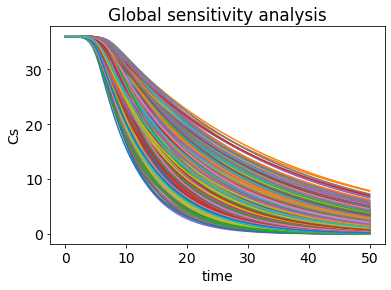

In [17]:
#Optimized parameters
Cxm_opt = 4.8169
kp2_opt = 0.0062
mu_opt = 1.1744
Y_Sp1_opt = 1.2764
Y_Sp2_opt = 0.4593
Y_SBP_opt = 0.0091
Y_SX_opt = -0.2271
alpha_opt = 0.1368
Beta_opt = 0.0722

# generate several output for random selections of parameters
N = 1000; 
Cxm_opt = np.random.uniform(4.8169*.8,4.8169*1.2,N);
kp2_opt = np.random.uniform(0.0062*.8,0.0062*1.2,N);
mu_opt = np.random.uniform(1.1744*.8,1.1744*1.2,N);
Y_Sp1_opt = np.random.uniform(1.2764*.8,1.2764*1.2,N);
Y_Sp2_opt = np.random.uniform(0.4593*.8,0.4593*1.2,N);
Y_SBP_opt = np.random.uniform(0.0091*.8,0.0091*1.2,N);
Y_SX_opt = np.random.uniform(-0.2271*.8,-0.2271*1.2,N);
alpha_opt = np.random.uniform(0.1368*.8,0.1368*1.2,N);
Beta_opt = np.random.uniform(0.0722*.8,0.0722*1.2,N);


Cs = np.zeros(N);

for m in np.arange(0,N,1):
    output = y = odeint(sens1, initial_values, timesteps, args = (Cxm_opt[m], kp2_opt[m], mu_opt[m], 
                                                                Y_Sp1_opt[m], 
                                                               Y_Sp2_opt[m],
                                                                Y_SBP_opt[m],
                                                                Y_SX_opt[m],
                                                                alpha_opt[m],
                                                                Beta_opt[m] ));
    plt.plot(timesteps,output[:,1]);
    plt.xlabel("time");
    plt.ylabel("Cs");
    plt.title ('Global sensitivity analysis')
    Cs[m]=output[-1,1];

Our fitted equation is y =  -3.6057922925340735 Cxm_opt +  -0.9396265544639332 kp2_opt + -0.3573758933697839 mu_opt -2.902837189993309 Y_Sp1_opt -0.543996949750742 Y_Sp2_opt -0.10845026725739992 Y_SBP_opt 0.046694799595708214 Y_SX_opt -2.698424377019781 alpha_opt 7.445968149743943 Beta_opt


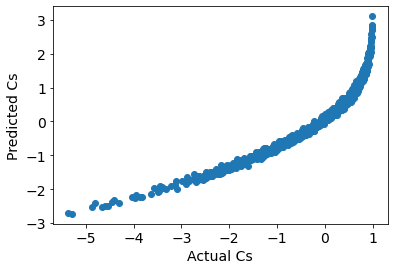

In [18]:
# Now we have our output of interest, called Cs. Using our old least squares code, let y = Cs and normalize the values by
# the value of Cs's steadystate for the nominal parameter values. This was calculated in step 1 above.

# Normalize y
y = (1.24-Cs)/1.24; # See first set of code to find this number


# Build our X. Normalize values
X = np.c_[(4.8169-Cxm_opt)/4.8169,(0.0062-kp2_opt)/0.0062,
          (1.1744-mu_opt)/1.1744, (1.2764 - Y_Sp1_opt)/1.2764,
         (0.4593-Y_Sp2_opt)/0.4593, (0.0091 - Y_SBP_opt)/0.0091,
         (-0.2271 - Y_SX_opt)/-0.2271, (0.1368 - alpha_opt)/0.1368, 
         (0.0722 - Beta_opt)/0.0722]

# Now can just do the linear least squares estimate
#===================================================

from numpy.linalg import inv
tmp = inv(np.matmul(np.transpose(X),X));

params = tmp @ np.transpose(X) @ y;
print("Our fitted equation is y = ",params[0], "Cxm_opt + ", params[1], "kp2_opt +", params[2],"mu_opt", params[3], "Y_Sp1_opt",
     params[4], "Y_Sp2_opt", params[5], "Y_SBP_opt", params[6], "Y_SX_opt", params[7], 
      "alpha_opt", params[8],"Beta_opt")

plt.plot(y,X @ params,"o");
plt.ylabel("Predicted Cs");
plt.xlabel("Actual Cs");